In [1]:
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, OneCycleLR
from torchvision import transforms
import matplotlib.pyplot as plt
import torchvision
import numpy as np

C:\Users\Sai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print(f"Using device: {device}")

Using device: cuda


In [3]:
class LogoDataset(Dataset):
    def __init__(self, logos_dir, logos_edge_maps_dir, transform=None):
        self.logos_dir = logos_dir
        self.logos_edge_maps_dir = logos_edge_maps_dir
        self.transform = transform
        self.image_names = os.listdir(logos_dir)

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = os.path.join(self.logos_dir, img_name)
        edge_map_path = os.path.join(self.logos_edge_maps_dir, img_name)

        image = Image.open(img_path).convert('L')
        edge_map = Image.open(edge_map_path)

        if self.transform:
            image = self.transform(image)
            edge_map = self.transform(edge_map)

        return image, edge_map

transform = transforms.Compose([
    transforms.Resize((1024, 1024)),  # Resize all images to 512x512
    transforms.ToTensor(),
])

logos_dir = 'Logos'
logos_edge_maps_dir = 'LogosEdgeMaps'

dataset = LogoDataset(logos_dir, logos_edge_maps_dir, transform=transform)

# Split the dataset into 80% training and 20% testing
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


In [4]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # B, 16, 64, 64
            nn.ReLU(True),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # B, 32, 32, 32
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # B, 64, 16, 16
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # B, 128, 8, 8
            nn.ReLU(True)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1), # B, 64, 16, 16
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # B, 32, 32, 32
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # B, 16, 64, 64
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # B, 1, 128, 128
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [5]:
model = Autoencoder()
model.to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(),  lr=1e-3)
# scheduler = StepLR(optimizer, step_size=5, gamma=0.5)  # Adjust step_size and gamma as needed


In [6]:
train_losses = []
train_accuracies=[]

# Training the model
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    correct_pred = 0
    total_samples = 0

    for images, edge_maps in train_loader:
        images, edge_maps = images.to(device), edge_maps.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, edge_maps)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
        # Calculate accuracy
        binarized_outputs = (outputs > 0.5).float()
        correct_pred += (binarized_outputs == edge_maps).sum().item()
        total_samples += edge_maps.numel()

    average_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(average_epoch_loss)
    training_accuracy = correct_pred / total_samples * 100
    train_accuracies.append(training_accuracy)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_epoch_loss:.4f}, Training Accuracy: {training_accuracy:.2f}%')


Epoch [1/20], Loss: 0.7515, Training Accuracy: 5.82%
Epoch [2/20], Loss: 0.4642, Training Accuracy: 71.24%
Epoch [3/20], Loss: 0.2438, Training Accuracy: 93.72%
Epoch [4/20], Loss: 0.1598, Training Accuracy: 93.80%
Epoch [5/20], Loss: 0.1335, Training Accuracy: 93.80%
Epoch [6/20], Loss: 0.1228, Training Accuracy: 93.80%
Epoch [7/20], Loss: 0.1171, Training Accuracy: 93.80%
Epoch [8/20], Loss: 0.1143, Training Accuracy: 93.80%
Epoch [9/20], Loss: 0.1124, Training Accuracy: 93.80%
Epoch [10/20], Loss: 0.1108, Training Accuracy: 93.80%
Epoch [11/20], Loss: 0.1095, Training Accuracy: 93.82%
Epoch [12/20], Loss: 0.1081, Training Accuracy: 93.82%
Epoch [13/20], Loss: 0.1068, Training Accuracy: 93.83%
Epoch [14/20], Loss: 0.1054, Training Accuracy: 93.83%
Epoch [15/20], Loss: 0.1040, Training Accuracy: 93.83%
Epoch [16/20], Loss: 0.1022, Training Accuracy: 93.83%
Epoch [17/20], Loss: 0.0997, Training Accuracy: 93.83%
Epoch [18/20], Loss: 0.0968, Training Accuracy: 93.83%
Epoch [19/20], Loss:

In [7]:
torch.save(model.state_dict(), f'autoencoder_edge_detector.pth')

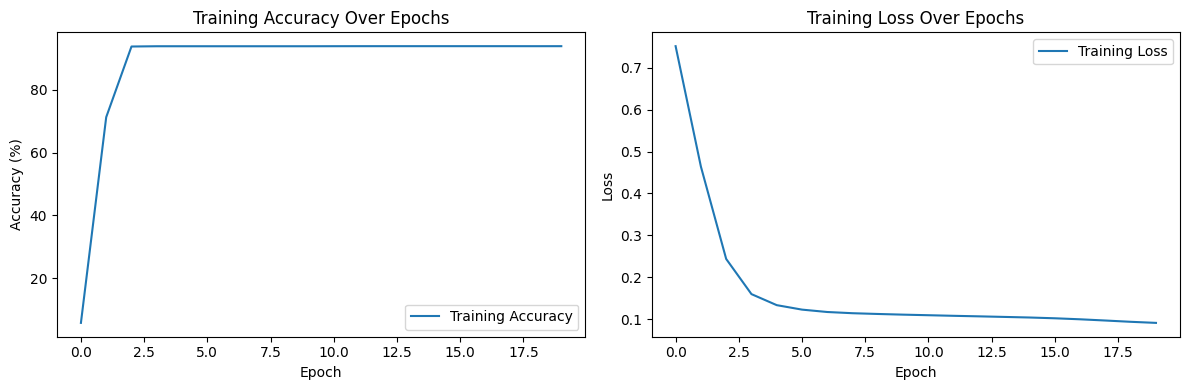

In [8]:
# Plotting training accuracies and losses
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Original Images


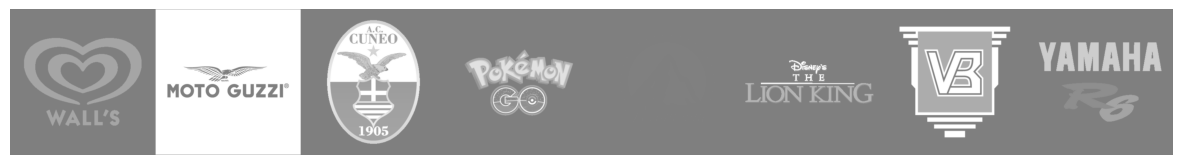

Ground Truth Edge Maps


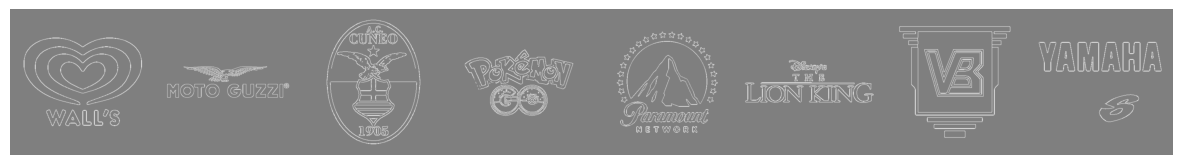

Autoencoder Reconstructed Edge Maps


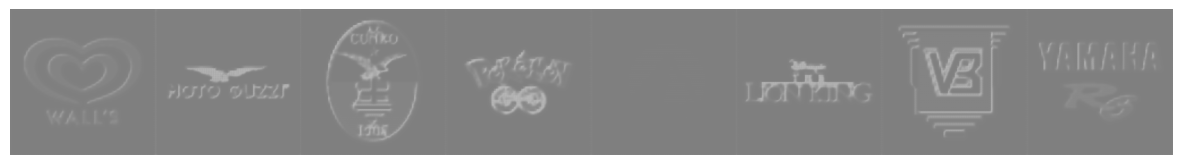

In [9]:
# Visualize the results
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.cpu().numpy()
    plt.figure(figsize=(15, 15))  # Set the size of the figure
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.axis('off')  # Turn off axis
    plt.show()

# Retrieve a batch of images and their corresponding edge maps
dataiter = iter(test_loader)
images, edge_maps = next(dataiter)
images, edge_maps = images.to(device), edge_maps.to(device)

# Get the reconstructed edge maps from the model
outputs = model(images)

# Visualize original images
print("Original Images")
imshow(torchvision.utils.make_grid(images[:8].cpu()))

# Visualize true edge maps
print("Ground Truth Edge Maps")
imshow(torchvision.utils.make_grid(edge_maps[:8].cpu()))

# Visualize reconstructed edge maps
print("Autoencoder Reconstructed Edge Maps")
imshow(torchvision.utils.make_grid(outputs[:8].cpu().detach()))
